# Metric Learning with Stochastic Gradient Descent

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import decomposition
from sklearn import metrics
import itertools

## Loading and visualizing data

In [2]:
if 0:  # use iris
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
else:  # use digits
    digits = datasets.load_digits()
    X = digits.data
    y = digits.target

    # on ne garde que les 7 premieres classes par simplicite
    X = X[y < 7]
    y = y[y < 7]

# standardize data
X -= X.mean(axis=0)
X /= X.std(axis=0)
X[np.isnan(X)] = 0.


def plot_2d(X, y):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    plt.figure()
    symlist = ['o', 's', '*', 'x', 'D', '+', 'p', 'v', 'H', '^']
    collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
               'fuchsia']

    labs = np.unique(y)
    idxbyclass = [y == labs[i] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(X[idxbyclass[i], 0], X[idxbyclass[i], 1], '+',
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.show()


/home/aurelien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


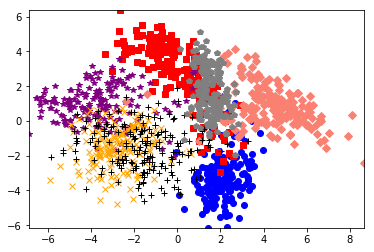

In [3]:
# on utilise PCA pour projeter les donnees en 2D
pca = decomposition.PCA(n_components=2)
X_2D = pca.fit_transform(X)
plot_2d(X_2D, y)

## Approche basée sur les paires

### Question 1

La fonction de perte proposée vise à séparer les paires positives et négatives : plus précisément, on cherche à avoir des distances sur les paires positives inférieures à 1 et celles sur les paires négatives supérieures à 3 (en effet la fonction de perte vaut 0 dans ce cas). Sinon, si la paire viole ces conditions, la perte est égale à la valeur de la violation.

### Question 2

Compléter la fonction `sgd_metric_learning_pairs`. Vous n'avez qu'à ajouter le calcul du sous-gradient de la perte sur la paire tirée aléatoirement.

In [4]:
def psd_proj(M):
    """ projection de la matrice M sur le cone des matrices semi-definies
    positives"""
    # calcule des valeurs et vecteurs propres
    eigenval, eigenvec = np.linalg.eigh(M)
    # on trouve les valeurs propres negatives ou tres proches de 0
    ind_pos = eigenval > 1e-10
    # on reconstruit la matrice en ignorant ces dernieres
    M = np.dot(eigenvec[:, ind_pos] * eigenval[ind_pos][np.newaxis, :],
               eigenvec[:, ind_pos].T)
    return M


def hinge_loss_pairs(X, pairs_idx, y_pairs, M):
    """Calcul du hinge loss sur les paires
    """
    diff = X[pairs_idx[:, 0], :] - X[pairs_idx[:, 1], :]
    return np.maximum(0., 1. + y_pairs.T * (np.sum(np.dot(M, diff.T) * diff.T,
                                                   axis=0) - 2.))


def sgd_metric_learning_pairs(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                              random_state=42):
    """Stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape

    # tirer n_eval paires aleatoirement
    # attention: celles-ci sont seulement utilisees pour evaluer la fonction objective
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires d'evaluation
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx,
                                           y_pairs, M)) + alpha * np.trace(M)
        idx = rng.randint(0, n_samples, 2)
        diff = X[idx[0], :] - X[idx[1], :]
        y_idx = 2.0 * (y[idx[0]] == y[idx[1]]) - 1.0
        gradient = (y_idx * np.outer(diff, diff) *
                    ((1. + y_idx * (np.dot(diff, M.dot(diff.T)) - 2.)) > 0))
        gradient += alpha * np.eye(n_features)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
        
    return M, pobj

### Question 3

Tester l'algorithme sur Iris et Digits en adaptant le pas et le nombre d'itérations afin de le faire converger.

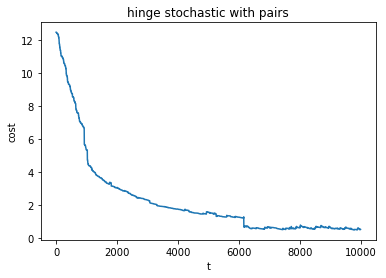

Nb de valeurs propres de M egales a 0:  3 / 64


In [5]:
n_features = X.shape[1]

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_pairs(X, y, 0.002, 0.0, 10000, 1000, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

# on regarde le nombre de valeurs propres egales a 0
e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])

### Question 4

Utiliser le code ci-dessous plus transformer les données et comparer visuellement les représentations en dimension 2.

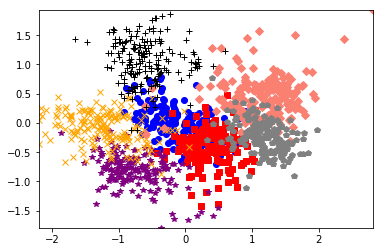

In [6]:
# calcul de la factorisation de cholesky
# on ajoute de tres faibles coefficients sur la diagonale pour eviter
# les erreurs numeriques
L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
X_proj = np.dot(X, L)

# on utilise PCA pour projeter les donnees en 2D
X_proj_2D = pca.fit_transform(X_proj)

plot_2d(X_proj_2D, y)

On remarque que malgré la projection PCA, les classes semblent former de meilleurs clusters que dans l'espace initial.

### Question 5

Pour un échantillon aléatoire de paires d’apprentissage, calculer les valeurs de distance et comparer la courbe ROC de la distance apprise avec celle de la distance Euclidienne. Calculer également l’aire sous la courbe ROC (AUC).

In [7]:
def distances_random_pairs(X, y, M, n_pairs=10000, random_state=42):
    """Draw random pairs and compute their Euclidean and Mahalanobis distance

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    M : array, shape (n_features, n_features)
        The matrix parameter of the Mahalanobis distance.
    n_pairs : int
        The number of pairs to sample
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    pairs = rng.randint(0, n_samples, (n_pairs, 2)) # tirer n_pairs paires aleatoires
    y_pairs = 2.0 * (y[pairs[:, 0]] == y[pairs[:, 1]]) - 1.0
    diff = X[pairs[:, 0], :] - X[pairs[:, 1], :]
    dist_euc = np.sqrt(np.sum(diff ** 2, axis=1))
    dist_M = np.sum(np.dot(M, diff.T) * diff.T, axis=0)
    return y_pairs, dist_euc, dist_M

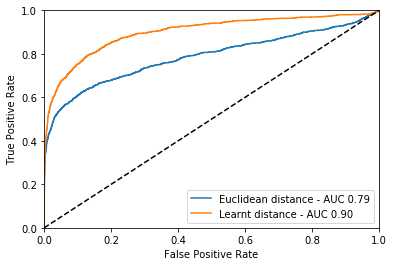

In [8]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

from sklearn.metrics import roc_curve, auc

# compute ROC curve for Euclidean distance and Mahalanobis
fpr_euc, tpr_euc, thresh_euc = roc_curve(y_pairs, -dist_euc)
fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)

# compute AUC for Euclidean distance and Mahalanobis
auc_euc = auc(fpr_euc, tpr_euc)
auc_M = auc(fpr_M, tpr_M)

# plot ROC curves
plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Cette courbe montre que la distance apprise est plus performante que la distance euclidienne pour identifier les paires d'exemples de même classe. Notons que l'AUC s'interprète comme la probabilité que pour deux paires (une positive, une négative) tirées aléatoirement, la distance pour la paire positive est inférieure à la distance pour la paire négative. Pour notre distance apprise, cette probabilité est égale à $0.9$.

### Question 6

Modifier la fonction `sgd_metric_learning_pairs` pour permettre une version mini-batch de l'algorithme. Explorer l'effet sur la convergence de l'algorithme.

In [9]:
def combs(a, r):
    """ compute all r-length combinations of elements in array; a faster
    than np.array(list(itertools.combinations(a, r)))
    """
    a = np.asarray(a)
    dt = np.dtype([('', a.dtype)] * r)
    b = np.fromiter(itertools.combinations(a, r), dt)
    return b.view(a.dtype).reshape(-1, r)

def sgd_metric_learning_pairs_minibatch(X, y, gamma, alpha, n_iter, n_eval,
                                        n_batch, batch_type, M_ini,
                                        random_state=42):
    """Mini-batch stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    n_batch : int
        Size of *subsample* for mini-batch (n_batch_pairs is given by
        n_batch*(n_batch-1)/2)
    batch_type : int
        0 if sample pairs directly, 1 if build pairs on subsample
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape
    # tirer n_eval paires aleatoirement
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    # number of pairs in the mini-batch
    n_batch_pairs = int(n_batch * (n_batch - 1) / 2)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
        
    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx,
                                           y_pairs, M)) + alpha * np.trace(M)
        if batch_type == 0:
            idx = rng.randint(0, n_samples, (n_batch_pairs, 2))
        elif batch_type == 1:
            idx_sample = rng.randint(0, n_samples, n_batch)
            idx = combs(idx_sample, 2)
        else:
            sys.exit('Error: batch_type parameter should be 0 or 1')
        diff = X[idx[:, 0], :] - X[idx[:, 1], :]
        y_idx = 2.0 * (y[idx[:, 0]] == y[idx[:, 1]]) - 1.0
        gradient = np.zeros((n_features, n_features))
        slack = (1. + y_idx.T * (np.sum(np.dot(M, diff.T) * diff.T,
                                 axis=0) - 2.)) > 0
        for i in range(0, n_batch_pairs):
            if slack[i]:
                gradient += y_idx[i] * np.outer(diff[i, :], diff[i, :])
        gradient /= n_batch_pairs
        gradient += alpha * np.eye(n_features)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
    return M, pobj


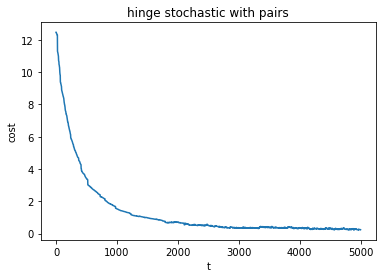

Nb de valeurs propres de M egales a 0:  3 / 64


In [10]:
n_features = X.shape[1]

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_pairs_minibatch(X, y, 0.005, 0.0, 5000, 1000, 5, 1, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

# check number of nonzero eigenvalues
e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])

On voit que la convergence est bien plus stable avec la version mini-batch, car on réduit la variance dans l'estimation du gradient.

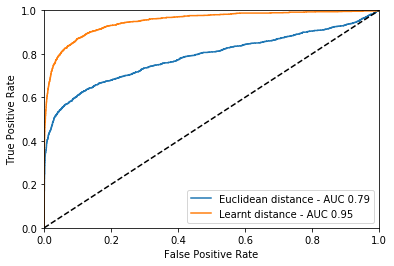

In [11]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)
auc_M = auc(fpr_M, tpr_M)

# plot ROC curves
plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Question 7

Modifier la fonction `sgd_metric_learning_pairs` pour permettre une régularisation par la norme trace. Explorer le compromis entre performance et réduction de dimension.

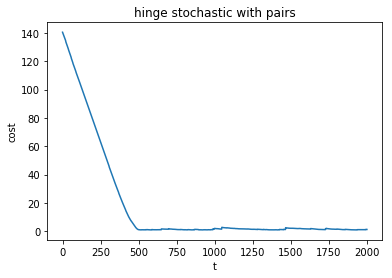

Nb de valeurs propres de M egales a 0:  54 / 64


In [12]:
M, pobj = sgd_metric_learning_pairs_minibatch(X, y, 0.001, 2.0, 2000, 1000, 5, 1, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

# check number of nonzero eigenvalues
e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])

L'effet de la régularisation par norme trace est très clair: on obtient ici une matrice avec seulement 10 valeurs propres non nulles (on projette donc dans un espace de dimension 10 au lieu de 64). On voit également que la régularisation stabilise l'optimisation.

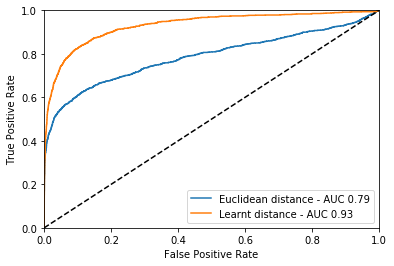

In [13]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)
auc_M = auc(fpr_M, tpr_M)

# plot ROC curves
plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Malgré la forte réduction de dimension, on arrive à maintenir un très bon niveau de performance.

## Approche basée sur les triplets

### Question 8

La fonction de perte proposée vise également à séparer les paires positives et négatives mais opère sur des triplets : on veut que chaque point de l'ensemble d'apprentissage soit plus proche d'un point de même classe que d'un point d'une classe différente avec une marge de 1 (en effet la fonction de perte vaut 0 dans ce cas). Sinon, si le triplet viole cette condition, la perte est égale à la valeur de la violation de marge.

### Question 9

Implémenter et expérimenter avec une version triplet de l'algorithme en complétant la fonction `sgd_metric_learning_triplets` ci-dessous. Vous n'avez qu'à ajouter le calcul du sous-gradient de la perte sur le triplet tiré aléatoirement.

In [14]:
def hinge_loss_triplets(X, triplets_idx, M):
    """Calcul du hinge loss sur les triplets
    """
    diffp = X[triplets_idx[:, 0], :] - X[triplets_idx[:, 1], :]
    diffn = X[triplets_idx[:, 0], :] - X[triplets_idx[:, 2], :]
    return np.maximum(0., 1. - np.sum(np.dot(M, diffn.T) * diffn.T, axis=0) +
                      np.sum(np.dot(M, diffp.T) * diffp.T, axis=0))


def generate_triplets(X, y, n_triplets, random_state=42):
    """Generation de triplets
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    triplets_idx = np.zeros((n_triplets, 3), dtype=int)
    triplets_idx[:, 0] = rng.randint(0, n_samples, (n_triplets,))
    for i in range(n_triplets):
        same_idx = np.where(y == y[triplets_idx[i, 0]])[0]
        diff_idx = np.where(y != y[triplets_idx[i, 0]])[0]
        triplets_idx[i, 1] = same_idx[rng.randint(0, same_idx.shape[0])]
        triplets_idx[i, 2] = diff_idx[rng.randint(0, diff_idx.shape[0])]
    return triplets_idx


def sgd_metric_learning_triplets(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                                 random_state=42):
    """Stochastic gradient algorithm for metric learning with triplets

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The labels.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of triplets to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape
    # generate n_eval triplets
    triplets_idx = generate_triplets(X, y, n_eval, random_state=random_state)
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_triplets(X, triplets_idx, M)
                          ) + alpha * np.trace(M)
        idx = generate_triplets(X, y, 1, random_state=random_state + t)[0]
        diffp = X[idx[0], :] - X[idx[1], :]
        diffn = X[idx[0], :] - X[idx[2], :]
        gradient = (np.outer(diffp, diffp) - np.outer(diffn, diffn)) * (
            1. - np.dot(diffn, M.dot(diffn.T)) + np.dot(diffp,
                                                        M.dot(diffp.T)) > 0)
        gradient += alpha * np.eye(n_features)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
    return M, pobj


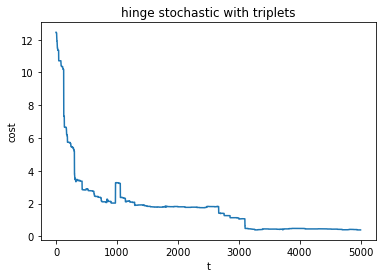

Nb de valeurs propres de M egales a 0:  0 / 64


In [15]:
M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_triplets(X, y, 0.001, 0.0, 5000, 1000, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with triplets')
plt.show()

# check number of nonzero eigenvalues
e, v = np.linalg.eig(M)
print("Nb de valeurs propres de M egales a 0: ", np.sum(e < 1e-12), "/", e.shape[0])

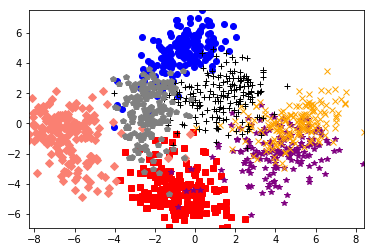

In [16]:
# calcul de la factorisation de cholesky
# on ajoute de tres faibles coefficients sur la diagonale pour eviter
# les erreurs numeriques
L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
X_proj = np.dot(X, L)

# on utilise PCA pour projeter les donnees en 2D
X_proj_2D = pca.fit_transform(X_proj)

plot_2d(X_proj_2D, y)

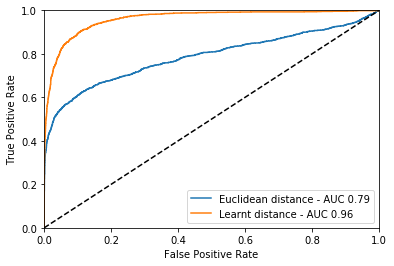

In [17]:
# on tire 10000 paires aleatoires et on calcule les distances
y_pairs, dist_euc, dist_M = distances_random_pairs(X, y, M, n_pairs=10000)

fpr_M, tpr_M, thresh_M = roc_curve(y_pairs, -dist_M)
auc_M = auc(fpr_M, tpr_M)

# plot ROC curves
plt.figure()
plt.plot(fpr_euc, tpr_euc, label='Euclidean distance - AUC %.2f' % auc_euc)
plt.plot(fpr_M, tpr_M, label='Learnt distance - AUC %.2f' % auc_M)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

On obtient des résulats encore meilleurs en AUC avec l'approche triplet. Cela n'est pas surprenant car le critère que l'on optimise ici est un critère "relatif" (on ne s'intéresse pas aux valeurs des distances elle-mêmes, on cherche simplement à avoir des distances sur les paires positives plus faibles que les distances sur les paires négatives) qui correspond bien à ce que calcule l'AUC.